<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

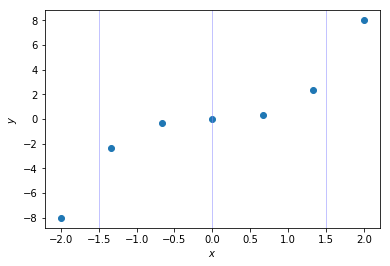

In [26]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

plt.axvline(x=-1.5, color='#8888ff', linewidth=0.5)
plt.axvline(x=0, color='#8888ff', linewidth=0.5)
plt.axvline(x=1.5, color='#8888ff', linewidth=0.5)

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

[-8.0, -1.3333333333333337, 0.8888888888888884, 8.0]


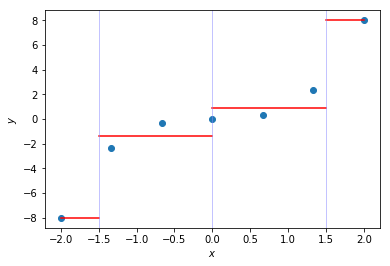

In [37]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

avg = []
# [-2; -1.5)
avg.append(np.average(y[0:1]))
plt.plot([-2, -1.5], [avg[0], avg[0]], 'r-')
# [-1.5; 0)
avg.append(np.average(y[1:3]))
plt.plot([-1.5, 0], [avg[1], avg[1]], 'r-')
# [0; 1.5)
avg.append(np.average(y[3:6]))
plt.plot([0, 1.5], [avg[2], avg[2]], 'r-')
# [1.5; 2]
avg.append(np.average(y[6:]))
plt.plot([1.5, 2], [avg[3], avg[3]], 'r-')
print(avg)

plt.axvline(x=-1.5, color='#8888ff', linewidth=0.5)
plt.axvline(x=0, color='#8888ff', linewidth=0.5)
plt.axvline(x=1.5, color='#8888ff', linewidth=0.5)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

[-3.5555555555555554, 2.6666666666666661]


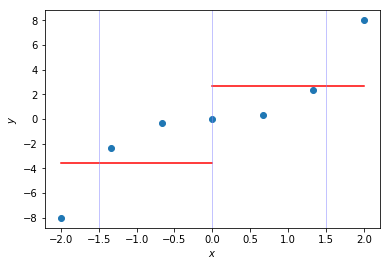

In [48]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

avg = []
# [-2; -0)
avg.append(np.average(y[0:3]))
plt.plot([-2, 0], [avg[0], avg[0]], 'r-')
# [0; 2]
avg.append(np.average(y[3:]))
plt.plot([0, 2], [avg[1], avg[1]], 'r-')
print(avg)

plt.axvline(x=-1.5, color='#8888ff', linewidth=0.5)
plt.axvline(x=0, color='#8888ff', linewidth=0.5)
plt.axvline(x=1.5, color='#8888ff', linewidth=0.5)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    pass

In [6]:
# Это слишком печально.

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

[-8.0, -1.3333333333333337, 0.8888888888888884, 8.0]


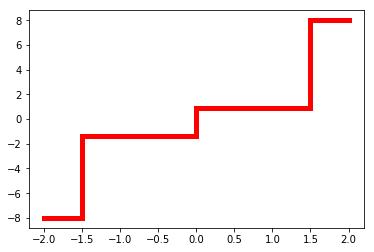

In [61]:
# А это разве не первая задачка? О_о
avg = []
# [-2; -1.5)
avg.append(np.average(y[0:1]))
plt.plot([-2, -1.5], [avg[0], avg[0]], 'r-', linewidth=5)
# [-1.5; 0)
avg.append(np.average(y[1:3]))
plt.plot([-1.5, -1.5], [avg[0], avg[1]], 'r-', linewidth=5)
plt.plot([-1.5, 0], [avg[1], avg[1]], 'r-', linewidth=5)
# [0; 1.5)
avg.append(np.average(y[3:6]))
plt.plot([0, 0], [avg[1], avg[2]], 'r-', linewidth=5)
plt.plot([0, 1.5], [avg[2], avg[2]], 'r-', linewidth=5)
# [1.5; 2]
avg.append(np.average(y[6:]))
plt.plot([1.5, 1.5], [avg[2], avg[3]], 'r-', linewidth=5)
plt.plot([1.5, 2], [avg[3], avg[3]], 'r-', linewidth=5)
print(avg)

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [175]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [64]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [176]:
import math

df['age_years'] = (df['age'] / 365.25).astype('int')
#pd.get_dummies(df, ['cholesterol', 'gluc'])

df_without_columns = df[df.columns.difference(['cardio', 'age'])]

df_without_columns.head()

,active,age_years,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight
id,,,,,,,,,,,
0,1,50,0,110,80,1,2,1,168,0,62.0
1,1,55,0,140,90,3,1,1,156,0,85.0
2,0,51,0,130,70,3,1,1,165,0,64.0
3,1,48,0,150,100,1,2,1,169,0,82.0
4,0,47,0,100,60,1,1,1,156,0,56.0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(df_without_columns, df['cardio'], random_state=17, test_size=0.3) # Ваш код здесь

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [166]:
trained_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
#knn = KNeighborsClassifier(n_neighbors=10)

trained_tree.fit(X_train, y_train)
#knn.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

[ 0.00953834  0.12613341  0.00343534  0.67576441  0.01974275  0.06661652
  0.00510572  0.01040404  0.0343418   0.00389392  0.04502374]
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.472562 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.472562 to fit



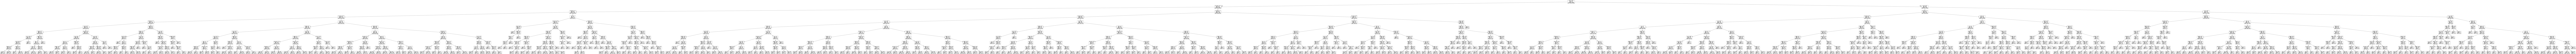

In [140]:
print(trained_tree.feature_importances_)

from sklearn import tree
from IPython.display import Image
import pydotplus
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(trained_tree, feature_names=df_without_columns.axes[1], out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('df_train.png')
Image(graph.create_png()) 

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [167]:
tree_pred = trained_tree.predict(X_valid)
accuracy_score(y_valid, tree_pred)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [164]:
# for depth in range(2, 11):
#     print(depth)
# tree_grid = GridSearchCV() # Ваш код здесь

tree_params = {'max_depth': range(2,11)}

tree_grid = GridSearchCV(trained_tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=100)]: Done  30 out of  45 | elapsed:  1.0min remaining:   30.7s
[Parallel(n_jobs=100)]: Done  45 out of  45 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=100,
       param_grid={'max_depth': range(2, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=True)

In [165]:
print(tree_grid.best_params_)
print(tree_grid.best_score_)
print(accuracy_score(y_valid, tree_grid.predict(X_valid)))
tree_grid.cv_results_

{'max_depth': 6}
0.732244897959
0.725666666667


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([ 0.03100171,  0.02580147,  0.0312017 ,  0.03700213,  0.04360251,
         0.04820271,  0.05220294,  0.05660324,  0.06220355]),
 'mean_score_time': array([ 0.00180011,  0.00180016,  0.00200005,  0.00200009,  0.00200014,
         0.00220013,  0.0026001 ,  0.00220013,  0.00220013]),
 'mean_test_score': array([ 0.7155102 ,  0.72771429,  0.73069388,  0.73114286,  0.7322449 ,
         0.72993878,  0.73020408,  0.72816327,  0.72634694]),
 'mean_train_score': array([ 0.71551022,  0.7277143 ,  0.73069389,  0.73331124,  0.73540818,
         0.73966328,  0.7444643 ,  0.75036736,  0.7569592 ]),
 'param_max_depth': masked_array(data = [2 3 4 5 6 7 8 9 10],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'rank_test_score': array([9

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

[2 3 4 5 6 7 8 9 10]
[ 0.7155102   0.72771429  0.73069388  0.73114286  0.7322449   0.72993878
  0.73020408  0.72816327  0.72634694]


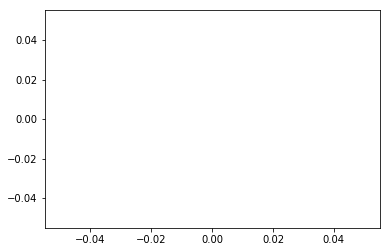

0.607380999584069%


In [170]:
print(tree_grid.cv_results_['param_max_depth'])
print(tree_grid.cv_results_['mean_test_score'])
plt.plot(x=tree_grid.cv_results_['param_max_depth'], y=tree_grid.cv_results_['mean_test_score'], color="red", linewidth=2.5, linestyle="-")
plt.show()

# Пик есть.
before_acc = 0.72128571428571431
after_acc = 0.725666666667
print (str(100.0 * (after_acc - before_acc) / before_acc) + "%")
# Но меньше одного процента.

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [ ]:
# Ваш код здесь

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [184]:
conditions_age = [
    (df['age_years'] >= 45) & (df['age_years'] < 50),
    (df['age_years'] >= 50) & (df['age_years'] < 55),
    (df['age_years'] >= 55) & (df['age_years'] < 60),
    (df['age_years'] >= 60) & (df['age_years'] < 65)]
choices_age = [1, 2, 3, 4]
df['age_quantum'] = np.select(conditions_age, choices_age, default=0)

conditions_press = [
    (df['ap_hi'] >= 120) & (df['ap_hi'] < 140),
    (df['ap_hi'] >= 140) & (df['ap_hi'] < 160),
    (df['ap_hi'] >= 160) & (df['ap_hi'] < 180)]
choices_press = [1, 2, 3]
df['press_quantum'] = np.select(conditions_press, choices_press, default=0)

conditions_gender = [
    df['gender'] == 1,
    df['gender'] == 2]
choices_gender = [False, True]
df['is_male'] = np.select(conditions_gender, choices_gender)

dummies = pd.get_dummies(df['cholesterol'], prefix='chol')
df_dummified = df.join(dummies)

dummies = pd.get_dummies(df['gluc'], prefix='gluc')
df_dummified = df_dummified.join(dummies)


df_without_columns_last = df_dummified[df_dummified.columns.difference(['cardio', 'age', 'age_years', 'ap_hi', 'gluc', 'gender'])]
df_without_columns_last.head()

#pavelmaminov+ods@yandex.ru

,active,age_quantum,alco,ap_lo,chol_1,chol_2,chol_3,cholesterol,gluc_1,gluc_2,gluc_3,height,is_male,press_quantum,smoke,weight
id,,,,,,,,,,,,,,,,
0,1,2,0,80,1,0,0,1,1,0,0,168,1,0,0,62.0
1,1,3,0,90,0,0,1,3,1,0,0,156,0,2,0,85.0
2,0,2,0,70,0,0,1,3,1,0,0,165,0,1,0,64.0
3,1,1,0,100,1,0,0,1,1,0,0,169,1,2,0,82.0
4,0,1,0,60,1,0,0,1,1,0,0,156,0,0,0,56.0


In [195]:
last_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
last_tree.fit(df_without_columns_last, df_without_columns_last.axes[0])
print(accuracy_score(y_valid, tree_grid.predict(X_valid)))

0.725666666667


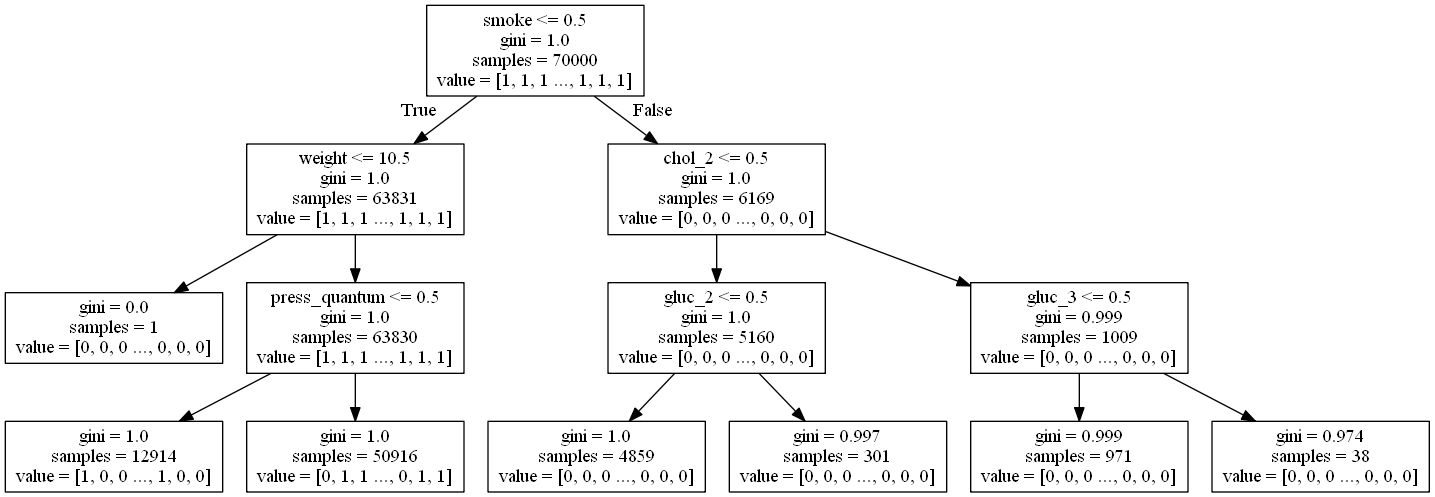

In [196]:
dot_data = tree.export_graphviz(last_tree, feature_names=df_without_columns_last.axes[1], out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('df_train.png')
Image(graph.create_png()) 